Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
import math

Define constant values

In [2]:
SAMPLE_RATE = 22050
SONG_DURATION = 30
DATASET_PATH = 'data'
SAMPLES_PER_SONG = SONG_DURATION * SAMPLE_RATE
NUMBER_OF_SEGMENTS = 5

Load dataset function

In [3]:
def load_dataset(dataset_path, n_fft, hop_length, n_mfcc, number_of_segments):
    
    samples_per_segment = int(SAMPLES_PER_SONG / number_of_segments)
    mfcc_length = math.ceil(samples_per_segment / hop_length)

    dataset = {"data": [], "label": []}

    # Load dataset
    for root, dirs, files in os.walk(dataset_path):
        for file in files:

            # Load signal from file
            file_path = os.path.join(root, file)
            signal, sample_rate = librosa.load(file_path)

            # Get label
            label = file.split(".")[0]

            # Cut signal on segments
            for i in range(number_of_segments):

                # Calculate start and end of segment
                start = samples_per_segment * i
                end = start + samples_per_segment

                # Get mfcc for segment
                segment = signal[start:end]
                mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, hop_length=hop_length, n_fft=n_fft, n_mfcc=n_mfcc)
                mfcc = mfcc.T
                
                # Add segment mfcc to dataset if segment has correct length
                if len(mfcc) == mfcc_length:
                    dataset['data'].append(mfcc.tolist())
                    dataset['label'].append(label)
                    print(f'{file}/{i}')

    return dataset

Version for Google Collab below (commented) - to make it working you need to have folder called data on your Google drive with all .wav files inside

In [ ]:
# from google.colab import drive
# import glob


# drive.mount('/content/drive')

# def load_dataset(dataset_path, n_fft, hop_length, n_mfcc, number_of_segments):
    
#     samples_per_segment = int(SAMPLES_PER_SONG / number_of_segments)
#     mfcc_length = math.ceil(samples_per_segment / hop_length)

#     dataset = {"data": [], "label": []}

#     # Load dataset
#     for file in glob.glob("/content/drive/MyDrive/dataset/*"):

#         # Load signal from file
#         signal, sample_rate = librosa.load(file)

#         # Get label
#         label = file.split('/')[-1].split('.')[0]

#         # Cut signal on segments
#         for i in range(number_of_segments):

#             # Calculate start and end of segment
#             start = samples_per_segment * i
#             end = start + samples_per_segment

#             # Get mfcc for segment
#             segment = signal[start:end]
#             mfcc = librosa.feature.mfcc(y=segment, sr=sample_rate, hop_length=hop_length, n_fft=n_fft, n_mfcc=n_mfcc)
#             mfcc = mfcc.T
            
#             # Add segment mfcc to dataset if segment has correct length
#             if len(mfcc) == mfcc_length:
#                 dataset['data'].append(mfcc.tolist())
#                 dataset['label'].append(label)
#                 print(f'{file}/{i}')

#     return dataset

In [4]:
dataset = load_dataset(DATASET_PATH, 2048, 512, 13, 5)

blues.00000.wav/0
blues.00000.wav/1
blues.00000.wav/2
blues.00000.wav/3
blues.00000.wav/4
blues.00001.wav/0
blues.00001.wav/1
blues.00001.wav/2
blues.00001.wav/3
blues.00001.wav/4
blues.00002.wav/0
blues.00002.wav/1
blues.00002.wav/2
blues.00002.wav/3
blues.00002.wav/4
blues.00003.wav/0
blues.00003.wav/1
blues.00003.wav/2
blues.00003.wav/3
blues.00003.wav/4
blues.00004.wav/0
blues.00004.wav/1
blues.00004.wav/2
blues.00004.wav/3
blues.00004.wav/4
blues.00005.wav/0
blues.00005.wav/1
blues.00005.wav/2
blues.00005.wav/3
blues.00005.wav/4
blues.00006.wav/0
blues.00006.wav/1
blues.00006.wav/2
blues.00006.wav/3
blues.00006.wav/4
blues.00007.wav/0
blues.00007.wav/1
blues.00007.wav/2
blues.00007.wav/3
blues.00007.wav/4
blues.00008.wav/0
blues.00008.wav/1
blues.00008.wav/2
blues.00008.wav/3
blues.00008.wav/4
blues.00009.wav/0
blues.00009.wav/1
blues.00009.wav/2
blues.00009.wav/3
blues.00009.wav/4
blues.00010.wav/0
blues.00010.wav/1
blues.00010.wav/2
blues.00010.wav/3
blues.00010.wav/4
blues.0001

Prepare dataset

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

X = np.array(dataset['data'])
y = np.array(dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [7]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [8]:
import keras
from keras.layers import LSTM, Dropout, Dense, BatchNormalization

input_shape = (len(X_train[0]), len(X_train[0][0]))

model = keras.Sequential()

model.add(LSTM(256,input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='sigmoid', kernel_regularizer=keras.regularizers.l1()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(48, activation='sigmoid', kernel_regularizer=keras.regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72704     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [9]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    verbose=1
)

Epoch 1/100
28/28 [==============================] - 16s 419ms/step - loss: 2.9906 - accuracy: 0.1309 - val_loss: 2.2161 - val_accuracy: 0.2358
Epoch 2/100
28/28 [==============================] - 11s 388ms/step - loss: 2.5629 - accuracy: 0.1871 - val_loss: 2.1356 - val_accuracy: 0.2745
Epoch 3/100
28/28 [==============================] - 11s 377ms/step - loss: 2.3710 - accuracy: 0.2200 - val_loss: 2.0329 - val_accuracy: 0.3220
Epoch 4/100
28/28 [==============================] - 10s 352ms/step - loss: 2.2261 - accuracy: 0.2432 - val_loss: 1.9581 - val_accuracy: 0.3427
Epoch 5/100
28/28 [==============================] - 10s 377ms/step - loss: 2.1161 - accuracy: 0.2664 - val_loss: 1.8989 - val_accuracy: 0.3667
Epoch 6/100
28/28 [==============================] - 17s 627ms/step - loss: 2.0347 - accuracy: 0.2859 - val_loss: 1.8121 - val_accuracy: 0.3727
Epoch 7/100
28/28 [==============================] - 16s 554ms/step - loss: 1.9404 - accuracy: 0.3105 - val_loss: 1.7381 - val_accuracy:

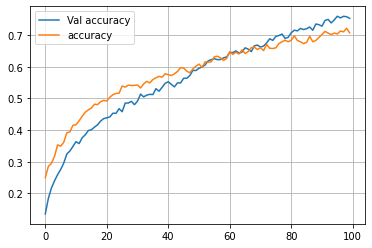

In [ ]:
plt.plot(history.history['accuracy'], label="Val accuracy")
plt.plot(history.history['val_accuracy'], label="accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')